In [1]:
import numpy as np
import pandas as pd

from astropy import coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import astroquery
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astropy.table import Table, join

Irsa.ROW_LIMIT = -1
Vizier.ROW_LIMIT = -1

import matplotlib.pyplot as plt

%matplotlib inline

# Get the data

In [2]:
obj = ["M87", 187.705930, 12.391123, 0.2]
# name, ra, dec, radius of cone
obj_name = obj[0]
obj_ra   = obj[1]
obj_dec  = obj[2]
cone_radius  = obj[3]

In [3]:
obj_coord = coordinates.SkyCoord(ra=obj_ra, dec=obj_dec, unit=(u.deg, u.deg), frame="icrs")

In [4]:
data_2mass = Irsa.query_region(obj_coord, catalog="fp_psc", radius=cone_radius * u.deg)
data_wise  = Irsa.query_region(obj_coord, catalog="allwise_p3as_psd", radius=cone_radius * u.deg)
__data_galex = Vizier.query_region(obj_coord, catalog='II/335', radius=cone_radius * u.deg)
data_galex = __data_galex[0]

In [5]:
num_2mass = len(data_2mass)
num_wise  = len(data_wise)
num_galex = len(data_galex)

print("Number of object in (2MASS, WISE, GALEX): ", num_2mass, num_wise, num_galex)

Number of object in (2MASS, WISE, GALEX):  182 2230 431


# Matching coordinates (3 Catalogs)

In [6]:
ra_2mass = data_2mass['ra']
dec_2mass = data_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = data_wise['ra']
dec_wise = data_wise['dec']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

ra_galex  = data_galex['RAJ2000']
dec_galex = data_galex['DEJ2000']
c_galex = coordinates.SkyCoord(ra=ra_galex, dec=dec_galex, unit=(u.deg, u.deg), frame="icrs")

In [31]:
sep_min = 2.0 * u.arcsec # minimum separation in arcsec

In [32]:
idx_2mass, idx_wise, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
c_2mass_wise = c_2mass[idx_2mass]
print("Only 2MASS and WISE: ", len(idx_2mass))

Only 2MASS and WISE:  164


# Plot W1-J vs W1

In [33]:
# from matching of 2 cats (2MASS and WISE) coordinate
w1 = data_wise[idx_wise]['w1mpro']
j = data_2mass[idx_2mass]['j_m']
w1j = w1-j

cutw1j = -1.7

# match between WISE and 2MASS
data_wise_2mass = data_wise[idx_wise] # WISE dataset

galaxy = data_wise_2mass[w1j<cutw1j] # https://academic.oup.com/mnras/article/448/2/1305/1055284

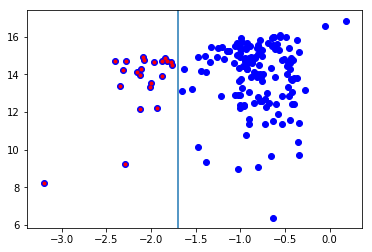

In [34]:
w1j_galaxy = w1j[w1j<cutw1j]
w1_galaxy = w1[w1j<cutw1j]
j_galaxy = j[w1j<cutw1j]

plt.scatter(w1j, w1, marker='o', color='blue')
plt.scatter(w1j_galaxy, w1_galaxy, marker='.', color="red")
          
plt.axvline(x=cutw1j) # https://academic.oup.com/mnras/article/448/2/1305/1055284

- W1-J < -1.7 => galaxy
- W1-J > -1.7 => stars

In [35]:
# + GALEX
___idx_2mass_wise_galex, idx_galex, d2d, d3d = c_galex.search_around_sky(c_2mass_wise, sep_min)

match_all_coord = c_galex[idx_galex]
print("Match all 3 cats: ", len(match_all_coord))

Match all 3 cats:  43


# Filter

In [36]:
### GALEX data which match with 2MASS and WISE!
match_galex = data_galex[idx_galex]
match_galex

RAJ2000,DEJ2000,r.fov,b,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fr,Nr
deg,deg,deg,,mag,mag,mag,mag,,,,,deg,deg
float64,float64,float64,uint8,float64,float32,float64,float32,int16,int16,int16,int16,float64,float64
187.705554,12.391376,0.453982,3,15.1366,0.0186,14.2607,0.0066,0,1,0,16,0.030242,0.012917
187.683336,12.426030,0.476495,3,20.3149,0.2242,19.5677,0.0972,0,1,0,1,0.005330,0.005089
187.658673,12.376673,0.500165,1,--,--,20.9030,0.1716,0,1,0,0,--,0.004826
187.766228,12.424715,0.395627,1,--,--,22.2858,0.3648,0,0,0,0,--,0.003236
187.674811,12.318272,0.490414,1,--,--,22.8001,0.4701,0,17,0,0,--,0.002694
187.646819,12.332413,0.515444,3,21.5733,0.4293,21.9569,0.3211,0,128,0,0,0.003232,0.003691
187.740441,12.471574,0.426366,1,--,--,20.7817,0.1502,0,0,0,0,--,0.002711
187.703882,12.486776,0.464243,1,--,--,15.6668,0.0114,0,1,0,0,--,0.001435


In [41]:
idx_2mass, idx, d2d, d3d = match_all_coord.search_around_sky(c_2mass, sep_min)
match_2mass = data_2mass[idx_2mass]
match_2mass

ra,dec,clon,clat,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,j_snr,h_m,h_cmsig,h_msigcom,h_snr,k_m,k_cmsig,k_msigcom,k_snr,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,hemis,xdate,scan,glon,glat,a,dist_opt,phi_opt,b_m_opt,vr_m_opt,nopt_mchs,ext_key,dist,angle,j_h,h_k,j_k,id
deg,deg,,,arcs,arcs,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,,,,,,deg,deg,,arcs,deg,mag,mag,,,arcs,deg,,,,
float64,float64,object,object,float64,float64,int32,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,int32,int32,object,object,int32,float64,float64,object,float64,int32,float64,float64,int32,int32,float64,float64,float64,float64,float64,object
187.706,12.391,12h30m49.43s,12d23m27.88s,0.16,0.14,179,12304942+1223278,11.439,0.109,0.109,926.5,11.284,0.222,0.222,441.9,10.733,0.151,0.152,510.8,EEE,222,111,000,666666,2,0,n,1999-12-07,151,283.778,74.491,0,--,--,--,--,0,--,0.162435,162.359481,0.155,0.551,0.706,0
187.683,12.426,12h30m43.90s,12d25m32.43s,0.28,0.23,4,12304389+1225324,16.525,0.143,0.143,8.6,15.865,0.218,0.218,6.5,15.356,--,--,--,BDU,220,110,000,162600,2,0,n,1999-12-07,151,283.659,74.517,U,1.4,166,18.7,17.2,1,--,148.41493,326.953147,0.66,--,--,14
187.659,12.376,12h30m38.08s,12d22m34.95s,0.16,0.13,0,12303807+1222349,14.46,0.03,0.032,57.3,13.979,0.037,0.038,36.9,14.021,0.048,0.049,24.7,AAA,222,111,000,666635,0,0,n,1999-12-07,151,283.63,74.463,U,0.8,148,16.4,15.5,1,--,174.51546,252.298202,0.481,-0.042,0.439,19
187.766,12.425,12h31m03.93s,12d25m28.24s,0.15,0.07,0,12310392+1225282,13.141,0.021,0.025,200.0,12.651,0.031,0.032,125.5,12.542,0.031,0.032,96.5,AAA,222,111,000,666666,0,0,n,1999-12-07,152,283.952,74.541,U,2.0,291,15.0,14.4,1,--,244.148338,60.498038,0.49,0.109,0.599,26
187.675,12.319,12h30m42.01s,12d19m06.83s,0.23,0.21,2,12304200+1219068,16.679,0.147,0.147,7.4,16.012,--,--,--,16.025,--,--,--,BUU,200,100,000,160000,0,0,n,1999-12-07,151,283.751,74.413,U,0.2,42,19.8,18.4,1,--,282.894154,202.585158,--,--,--,29
187.647,12.332,12h30m35.28s,12d19m55.82s,0.23,0.21,178,12303527+1219558,16.603,0.14,0.14,8.0,15.688,0.164,0.164,7.7,15.115,0.125,0.125,9.0,BCB,222,111,000,160506,0,0,n,1999-12-07,151,283.639,74.418,U,0.4,352,19.0,18.8,1,--,296.628512,224.330002,0.915,0.573,1.488,32
187.741,12.472,12h30m57.74s,12d28m17.97s,0.14,0.13,0,12305773+1228179,9.859,0.019,0.022,3970.4,9.251,0.032,0.033,2874.2,9.139,0.021,0.023,2217.3,AAA,222,111,000,666666,0,0,n,1999-12-07,151,283.809,74.578,0,--,--,--,--,0,--,314.483337,22.783954,0.608,0.112,0.72,35
187.704,12.487,12h30m48.93s,12d29m12.13s,0.13,0.13,90,12304893+1229121,7.029,0.013,0.021,53805.9,6.635,0.047,0.049,31982.3,6.459,0.009,0.017,26171.0,AAA,111,111,000,666666,0,0,n,1999-12-07,151,283.663,74.582,T,0.1,201,9.55,8.65,2,--,344.169634,358.808578,0.394,0.176,0.57,41


In [43]:
ra_2mass = match_2mass['ra']
dec_2mass = match_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")


idx_wise, idx, d2d, d3d = c_2mass.search_around_sky(c_wise, sep_min)
match_wise = data_wise[idx_wise]
match_wise

designation,ra,dec,clon,clat,sigra,sigdec,sigradec,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,pmra,sigpmra,pmdec,sigpmdec,cc_flags,ext_flg,var_flg,ph_qual,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,dist,angle,id
,deg,deg,,,arcs,arcs,arcs,mag,mag,,,mag,mag,,,mag,mag,,,mag,mag,,,,,,,,,maspyr,maspyr,maspyr,maspyr,,,,,,,,,,,,,,arcs,deg,
object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,int32,int32,int32,object,int32,object,object,object,int32,int32,int32,int32,int32,int32,int32,int32,float64,float64,object
J123049.43+122328.0,187.706,12.391,12h30m49.43s,12d23m28.04s,0.0284,0.0291,-0.0055,8.237,0.022,49.1,111.9,8.159,0.019,57.1,78.62,6.975,0.014,75.5,21.24,5.046,0.035,31.3,5.511,1,0,0.0,0.0,0.0,0.0,-308,33,-586,33,0000,5,n211,AAAA,1222,30,30,25,25,13,13,14,14,0.122982,84.287626,0
J123043.89+122533.2,187.683,12.426,12h30m43.90s,12d25m33.22s,0.0697,0.0732,-0.0059,14.213,0.031,35.4,4.326,14.475,0.061,17.7,0.8815,10.791,0.099,10.9,0.9511,8.591,--,1.3,0.9951,1,0,0.0,0.0,0.0,0.0,173,176,85,188,0000,3,000n,AAAU,1222,30,30,21,25,9,13,0,14,149.088795,327.109751,209
J123038.08+122234.8,187.659,12.376,12h30m38.08s,12d22m34.86s,0.0653,0.0665,-0.0104,13.844,0.029,37.4,1.431,14.108,0.054,20.2,0.8868,12.452,--,0.0,0.9366,8.844,--,0.4,0.9972,1,0,0.0,0.0,0.0,0.0,0,110,0,119,0000,2,00nn,AAUU,1222,29,29,24,24,0,13,1,14,174.436209,252.255996,295
J123103.89+122528.1,187.766,12.424,12h31m03.90s,12d25m28.14s,0.0439,0.0431,-0.0101,12.464,0.024,46.2,1.078,12.556,0.026,42.4,0.9662,12.533,0.49,2.2,0.9208,8.613,--,1.2,0.9314,1,0,0.0,0.001,0.0,0.0,28,53,-2,55,0000,2,11nn,AACU,1244,32,32,26,26,0,13,1,14,243.693475,60.464001,626
J123042.01+121907.2,187.675,12.319,12h30m42.02s,12d19m07.30s,0.3143,0.3446,0.0604,16.858,0.107,10.1,0.8859,16.461,--,1.9,0.8657,12.558,--,-0.9,0.8696,9.052,--,-1.5,1.071,1,0,0.0,0.0,0.0,0.0,-164,1236,555,1348,0000,2,nnnn,AUUU,1222,7,31,0,25,0,12,0,14,282.405271,202.594872,708
J123035.26+121955.4,187.647,12.332,12h30m35.27s,12d19m55.46s,0.0719,0.0762,-0.0017,14.723,0.032,34.1,1.051,14.428,0.051,21.3,0.9648,11.61,0.214,5.1,1.109,8.931,--,0.3,0.8999,1,0,0.0,0.0,0.0,0.0,51,189,271,204,0000,0,11nn,AABU,1222,31,31,25,26,2,13,0,14,296.974558,224.29915,740
J123057.68+122816.4,187.740,12.471,12h30m57.68s,12d28m16.42s,0.0351,0.0345,-0.0065,9.057,0.023,47.2,1.36,9.122,0.019,55.7,1.511,9.025,0.031,35.1,0.7606,8.208,--,1.7,0.9555,1,0,0.0,0.0,0.0,0.0,8,35,-193,35,HH00,0,nn1n,AAAU,1244,31,31,25,25,12,12,0,13,312.73542,22.752056,780
J123048.91+122912.0,187.704,12.487,12h30m48.91s,12d29m12.03s,0.0342,0.032,-0.007,6.395,0.084,13.0,0.277,6.402,0.024,46.1,1.76,6.446,0.016,66.9,1.251,6.37,0.059,18.4,1.038,1,0,0.117,0.053,0.0,0.0,-232,37,99,35,0000,0,0000,AAAA,1222,31,31,25,25,13,13,14,14,344.079121,358.753293,851


## Join table

In [44]:
# joindata = Table([match_2mass['j_m'], 
#                   match_2mass['j_m']-match_2mass['h_m'], 
#                   match_2mass['j_m']-match_2mass['k_m'],
#                   match_2mass['j_m']-match_wise['w1mpro'], 
#                   match_2mass['j_m']-match_wise['w2mpro'],
#                   match_2mass['j_m']-match_wise['w3mpro'],
#                   match_2mass['j_m']-match_wise['w4mpro'],
#                   match_2mass['j_m']-match_galex['NUVmag']], 
#                   names=('J', 'J-H', 'J-K', 'J-W1', 'J-W2', 'J-W3', 'J-W4', 'J-NUV'))

In [45]:
joindata = np.array([match_2mass['j_m'], 
                  match_2mass['j_m']-match_2mass['h_m'], 
                  match_2mass['j_m']-match_2mass['k_m'],
                  match_2mass['j_m']-match_wise['w1mpro'], 
                  match_2mass['j_m']-match_wise['w2mpro'],
                  match_2mass['j_m']-match_wise['w3mpro'],
                  match_2mass['j_m']-match_wise['w4mpro'],
                  match_2mass['j_m']-match_galex['NUVmag']])

joindata = joindata.T

In [46]:
# joindata = np.array([match_2mass['j_m'], match_2mass['h_m'], match_2mass['k_m'], 
#                      match_wise['w1mpro'], match_wise['w2mpro'], match_wise['w3mpro'], match_wise['w4mpro'],
#                      match_galex['NUVmag']])

# joindata = joindata.T

In [47]:
len(match_2mass['j_m'])

43

In [48]:
len(match_wise['w3mpro'])

43

# Analysis

### PCA

In [49]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

X = scale(joindata)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

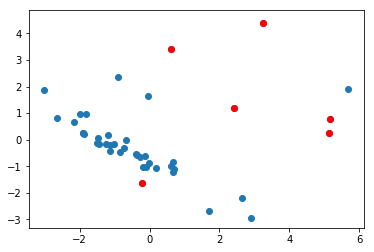

In [50]:
plt.scatter(X_r[:,0], X_r[:,1])
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], color="red")  

### DBSCAN

In [51]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = scale(joindata)

db = DBSCAN(eps=2, min_samples=3).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print(labels)

Estimated number of clusters: 2
[-1 -1  0  0  1 -1  0  0  1  0 -1  0  0  0  0  0 -1  0 -1  0  0  0  0  0
  0 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


#### Plot J-W1 vs J

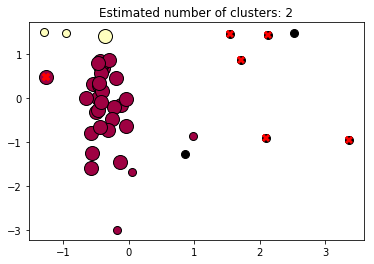

In [52]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    
    ## J vs J-W1
    
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 3], xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)
    
    for i, name in enumerate(match_wise['designation']):
        for galaxyname in galaxy['designation']:
            if name == galaxyname:
                plt.plot(X[i,3], X[i,0], marker="X", markerfacecolor='red', markeredgecolor='none', markersize=8)  

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### t-SNE

In [53]:
from sklearn.manifold import TSNE
X = scale(joindata)
X_r = TSNE(n_components=2).fit_transform(X)

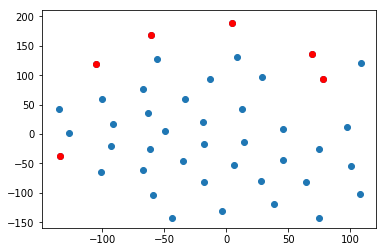

In [54]:
plt.scatter(X_r[:,0], X_r[:,1])
for i, name in enumerate(match_wise['designation']):
    for galaxyname in galaxy['designation']:
        if name == galaxyname:
            plt.scatter(X_r[i,0], X_r[i,1], color="red")  